## INSTALLING DETECTRON2

In [1]:
# install dependencies: 
#!conda install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.9.0 False


'gcc' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
#assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!conda install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime


usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

##  Train on VisualMRC dataset

In [4]:
# download, decompress the data
!unzip /content/drive/MyDrive/Capstone/Code/images2.zip > /dev/null

In [5]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_dicts():
    json_file = "/content/drive/MyDrive/Capstone/Code/whole_annotate_train.json"
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = "/content/"+ v["filename"]
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            #assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": anno['label'],
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

train=""
DatasetCatalog.register("VisualMRC_train", lambda train=train: get_dicts())
MetadataCatalog.get("VisualMRC_train").set(thing_classes=['Caption','Data','Title','Image','List','other','Paragraph','Subdata','Subtitle'])
VisualMRC_metadata = MetadataCatalog.get("VisualMRC_train")
print(VisualMRC_metadata)

Metadata(name='VisualMRC_train', thing_classes=['Caption', 'Data', 'Title', 'Image', 'List', 'other', 'Paragraph', 'Subdata', 'Subtitle'])


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



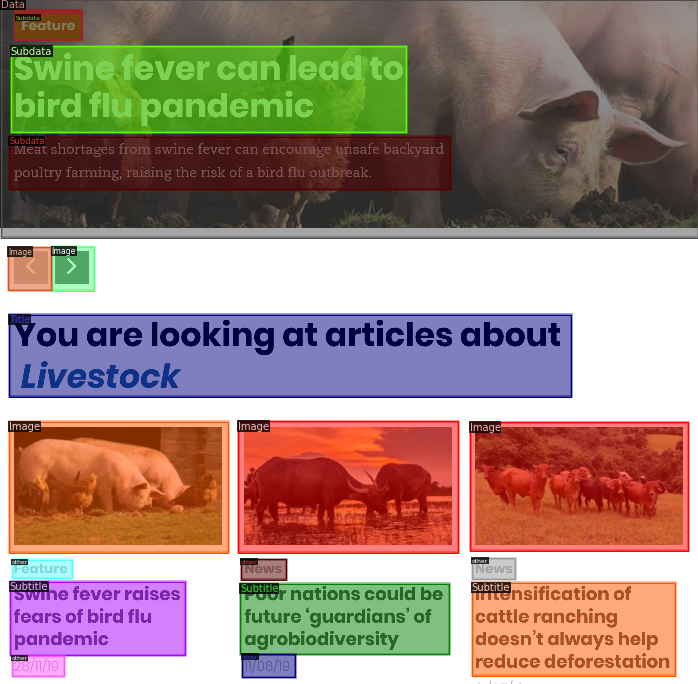

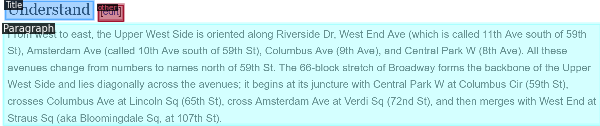

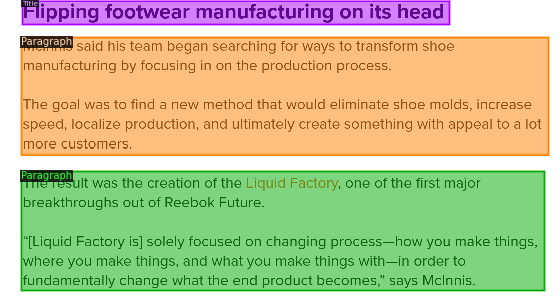

In [6]:
dataset_dicts = get_dicts()
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=VisualMRC_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Training on VisualMRC Dataset 

In [7]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("VisualMRC_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 5
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9   #(see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/26 11:22:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:40, 6.08MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (10, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (10,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (36, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.


[05/26 11:24:01 d2.engine.train_loop]: Starting training from iteration 0
[05/26 11:25:40 d2.utils.events]:  eta: 1:21:58  iter: 19  total_loss: 5.868  loss_cls: 2.315  loss_box_reg: 0.4596  loss_rpn_cls: 2.645  loss_rpn_loc: 0.4782  time: 4.8768  data_time: 0.1284  lr: 1.9981e-05  max_mem: 8386M
[05/26 11:27:18 d2.utils.events]:  eta: 1:20:18  iter: 39  total_loss: 3.374  loss_cls: 1.826  loss_box_reg: 0.7266  loss_rpn_cls: 0.3394  loss_rpn_loc: 0.3355  time: 4.8973  data_time: 0.1107  lr: 3.9961e-05  max_mem: 8386M
[05/26 11:28:57 d2.utils.events]:  eta: 1:19:08  iter: 59  total_loss: 2.329  loss_cls: 1.097  loss_box_reg: 0.7943  loss_rpn_cls: 0.08235  loss_rpn_loc: 0.3021  time: 4.9218  data_time: 0.0850  lr: 5.9941e-05  max_mem: 8386M
[05/26 11:30:36 d2.utils.events]:  eta: 1:17:20  iter: 79  total_loss: 2.066  loss_cls: 0.8856  loss_box_reg: 0.83  loss_rpn_cls: 0.0572  loss_rpn_loc: 0.2817  time: 4.9289  data_time: 0.1051  lr: 7.9921e-05  max_mem: 8386M
[05/26 11:32:17 d2.utils.ev

### Inference & evaluation using the trained model
Now, let's run inference with the trained model on the validation dataset. First, let's create a predictor using the model we just trained:

In [8]:
def get_val_dicts():
    json_file = "/content/drive/MyDrive/Capstone/Code/whole_annotate_validation.json"
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = "/content/"+ v["filename"]
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            #assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": anno['label'],
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

val=""
DatasetCatalog.register("VisualMRC_val", lambda val=val: get_val_dicts())
MetadataCatalog.get("VisualMRC_val").set(thing_classes=['Caption','Data','Title','Image','List','other','Paragraph','Subdata','Subtitle'])

Metadata(name='VisualMRC_val', thing_classes=['Caption', 'Data', 'Title', 'Image', 'List', 'other', 'Paragraph', 'Subdata', 'Subtitle'])

In [9]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [10]:
f=open('config.yml','w')
f.write(cfg.dump())
f.close()

Then, we randomly select several samples to visualize the prediction results.

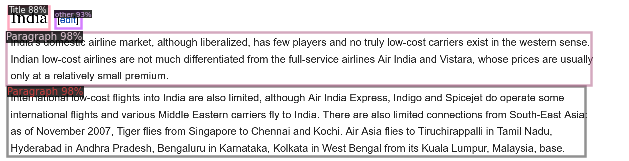

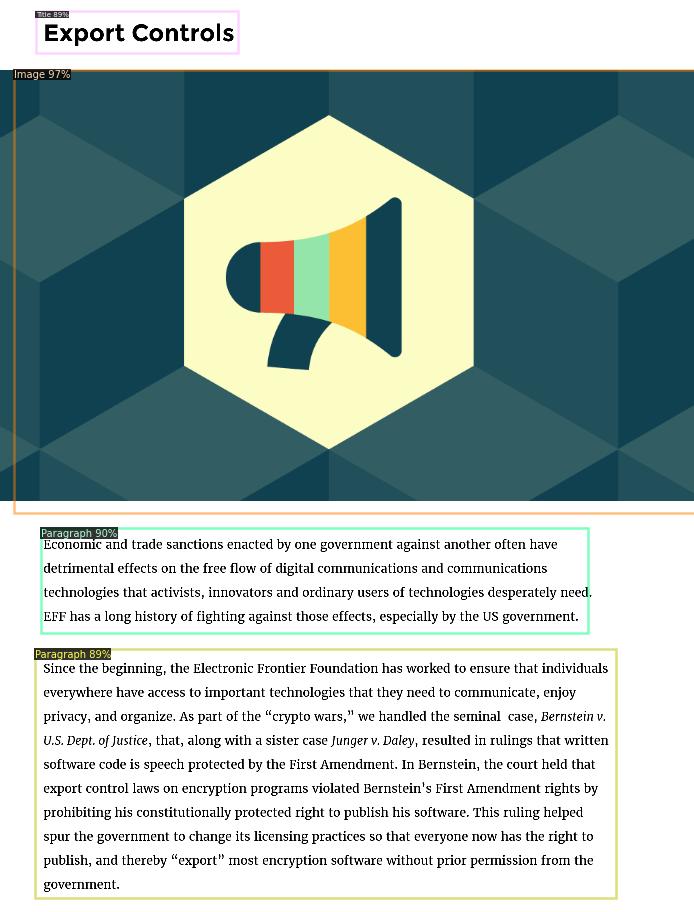

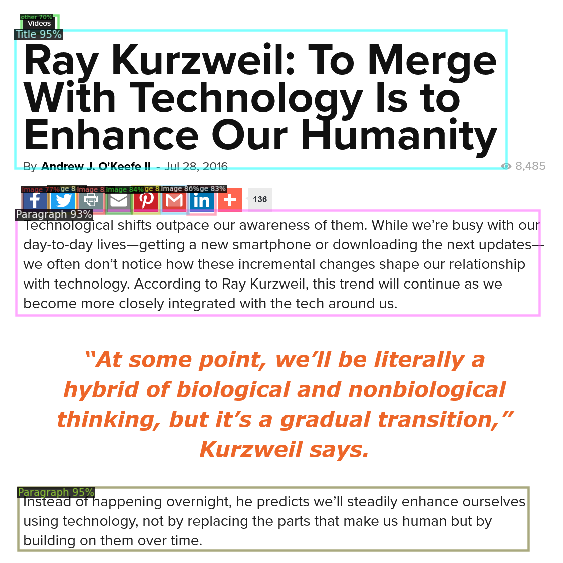

In [11]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_val_dicts()
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=VisualMRC_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.

In [12]:
#import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("VisualMRC_val", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "VisualMRC_val")

#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [05/26 12:46:51 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/26 12:46:51 d2.evaluation.coco_evaluation]: 'VisualMRC_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[05/26 12:46:51 d2.data.datasets.coco]: Converting annotations of dataset 'VisualMRC_val' to COCO format ...)
[05/26 12:47:39 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/26 12:47:46 d2.data.datasets.coco]: Conversion finished, #images: 5091, #annotations: 33260
[05/26 12:47:46 d2.data.datasets.coco]: Caching COCO format annotations at '/output/VisualMRC_val_coco_format.json' ...
[05/26 12:48:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/26 12:48:35 d2.data.common]: Serializing 5091 elements to byte tensors and co

OrderedDict([('bbox',
              {'AP': 19.76587390269006,
               'AP-Caption': 11.873625021144552,
               'AP-Data': 0.0,
               'AP-Image': 40.88136493033531,
               'AP-List': 0.0,
               'AP-Paragraph': 60.50357272102696,
               'AP-Subdata': 0.0,
               'AP-Subtitle': 1.4803304378482827,
               'AP-Title': 47.33206686465846,
               'AP-other': 15.821905149196969,
               'AP50': 30.432027460868067,
               'AP75': 20.73329789173765,
               'APl': 22.082311995470157,
               'APm': 9.659002592986125,
               'APs': 3.106111666384596})])

### Prediction using Trained Model

In [4]:
cfg = get_cfg()
cfg.merge_from_file("Output/config.yml")

cfg.MODEL.WEIGHTS = "Output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE = "cpu"
predictor = DefaultPredictor(cfg)
#MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes = ['Caption','Data','Title','Image','List','other','Paragraph','Subdata','Subtitle']

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [8]:
from detectron2.utils.visualizer import ColorMode
im = cv2.imread('struct_image.png')
output = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata= MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
               scale=0.8,
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
      )
v = v.draw_instance_predictions(output["instances"].to("cpu"))
cv2.imshow("img",v.get_image()[:, :, ::-1])
cv2.waitKey()
cv2. destroyAllWindows()

In [9]:
pred_classes=output["instances"].pred_classes
scores=output["instances"].scores
roi=output["instances"].pred_boxes
print(pred_classes)
print(scores)
print(roi)

tensor([6, 6, 6, 6, 6, 6, 2, 6, 6])
tensor([0.9673, 0.9552, 0.9505, 0.9416, 0.9410, 0.9171, 0.7726, 0.6654, 0.6250])
Boxes(tensor([[ 14.9107, 189.8543, 718.9941, 362.1411],
        [ 19.7588, 575.1085, 709.9138, 733.8769],
        [ 17.7326, 366.9642, 718.4984, 479.6810],
        [  6.2253, 482.5208, 713.7783, 574.5756],
        [  7.6293,  84.1859, 714.7963, 137.1097],
        [  0.0000, 139.0997, 716.8160, 190.8750],
        [263.6442,  14.3384, 479.5293,  54.9385],
        [ 17.8085, 203.4108, 718.3673, 709.3414],
        [ 11.3662,  81.1150, 725.5019, 190.9168]]))


In [10]:
pred_classes=pred_classes.cpu().detach().numpy()
print(pred_classes)

[6 6 6 6 6 6 2 6 6]


In [11]:
roi=roi.tensor.cpu().detach().numpy()
print(roi)

[[ 14.910722  189.85428   718.99414   362.1411   ]
 [ 19.75878   575.10846   709.91376   733.8769   ]
 [ 17.732615  366.96417   718.4984    479.681    ]
 [  6.2252774 482.5208    713.7783    574.57556  ]
 [  7.629347   84.18587   714.7963    137.10968  ]
 [  0.        139.0997    716.81604   190.87498  ]
 [263.64417    14.338383  479.52933    54.93854  ]
 [ 17.808514  203.41083   718.3673    709.3414   ]
 [ 11.366208   81.115036  725.5019    190.9168   ]]


In [14]:
import cv2
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r"E:\Program Files\Tesseract-OCR\tesseract.exe"

image = cv2.imread('struct_image.png', 0)
thresh = 255 - cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

data=[]

for i in range(0,len(pred_classes)):
  if(pred_classes[i]==6 and scores[i]<0.90):
    continue
  ROI = thresh[int(roi[i][1]):int(roi[i][3]),int(roi[i][0]):int(roi[i][2])]
  data.append(pytesseract.image_to_string(ROI, lang='eng',config='--psm 6'))

data=[s.replace('\n',' ')  for s in data]
data=[s.replace('\x0c','')  for s in data]
print(data)


['In this series, we travel to the past and leam about historical mapmakers, from Claudius Ptolemy (who stated the idea that the Earth is at the center of the universe) to Gerardus Mercator (who created one of th most widely used map projections) and more. This series goes into tremendous detail on the cartographer\'s life and maps. We then joumey to the present era to leam about map projections and the diverse types of maps used today. You might ask, “What is the difference between the two? They sound the same to me." No map projection is perfect, because you cannot really flatten a sphere into a rectangle An uncolored projection could be used in many ways. We could use it for population concentration, highways, land elevation, and so many other things! ', 'The Mapping the World 8-book set goes into amazing levels of detail. It is a long read, but it gives an immense range and amount of information that you would net find in any other book or series on maps. The flowing way the chapte